# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
pic = plt.imread('images/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

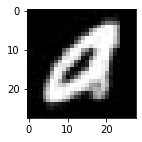

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

## Основные задания

In [5]:
import os
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

In [6]:
def get_data_and_targets_lst(path):
    data=[]
    targets=[]
    for root, currentDirectory, files in os.walk(path):
        for file in files:
            pic = plt.imread(os.path.join(root, file))
            pic = torch.tensor(np.transpose(pic, axes=(1, 0, 2)))
            pic = torch.div(pic, 255)
            target = ord(file[0]) - ord('a')
            data.append(pic)
            targets.append(target)
    return data,targets

In [7]:
class MyDataset(torch.utils.data.Dataset): 
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        #return {'sample': self.x[idx], 'target': self.y[idx]}
        return self.x[idx],self.y[idx]

In [8]:
X,y = get_data_and_targets_lst("images/train")

In [9]:
X[60000].dtype

torch.float32

15


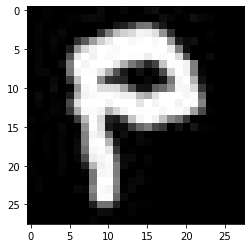

In [10]:
plt.imshow(X[60000])
print(y[60000])

In [11]:
len(y)

65000

In [12]:
# for i in range(len(y)):
#     ls = [0 for a in range(26)]
#     ls[y[i]] = 1
#     y[i]= ls

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [14]:
len(X_test), len(y_test)

(13000, 13000)

In [15]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
#train_dataset.__getitem__(40000)

In [16]:
batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for batch, (X, y) in enumerate(train_dataloader):
    print(batch)
    print(y)
    print("Shape of X [N, C, H, W]: ", X.shape)
    #NHWC now
    print("Shape of y: ", y.shape, y.dtype)
    break

0
tensor([ 9, 11, 11, 10, 17,  2,  2, 10, 25, 19, 21,  4,  1, 22, 17, 15, 20,  7,
         1,  2, 12, 20,  2, 16, 22,  8, 17, 25, 21, 15,  2,  4,  7, 19, 10,  1,
         2, 17, 14,  3,  7, 13,  7, 20, 24, 21, 11, 17, 17, 23,  3,  1,  7, 18,
        11, 16,  9, 25, 14,  3,  5, 24,  2,  3])
Shape of X [N, C, H, W]:  torch.Size([64, 28, 28, 3])
Shape of y:  torch.Size([64]) torch.int64


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #print(pred.shape)
            #print(loss_fn(pred, y).item())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [50]:
def get_model_accuracy(dataloader, model):
    size = len(dataloader.dataset)
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct / size       

In [79]:
def get_all_model_predictions(dataloader, model):
    size = len(dataloader.dataset)
    correct = 0
    predictions = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predictions.extend(pred.argmax(1))
#             if len(pred.argmax(1))>1:
#                 print(pred.argmax(1))
    return list(map(lambda x : x.item(), predictions)) 

In [20]:
def learning_cycle(epochs, model, loss_fn, optimizer):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
        #print("Done!")
    

# 1.1

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [22]:
model_lin3 = NeuralNetwork()

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lin3.parameters(), lr=0.001)
learning_cycle(100, model_lin3, loss_fn, optimizer)

Epoch 1
-------------------------------
loss: 0.756594  [    0/52000]
loss: 0.670591  [ 6400/52000]
loss: 0.819595  [12800/52000]
loss: 0.707328  [19200/52000]
loss: 0.784801  [25600/52000]
loss: 0.574056  [32000/52000]
loss: 0.716980  [38400/52000]
loss: 0.568250  [44800/52000]
loss: 0.442809  [51200/52000]
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.632157 

Epoch 2
-------------------------------
loss: 0.750580  [    0/52000]
loss: 0.666563  [ 6400/52000]
loss: 0.814169  [12800/52000]
loss: 0.703332  [19200/52000]
loss: 0.780341  [25600/52000]
loss: 0.570770  [32000/52000]
loss: 0.712623  [38400/52000]
loss: 0.564825  [44800/52000]
loss: 0.438962  [51200/52000]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.628283 

Epoch 3
-------------------------------
loss: 0.744707  [    0/52000]
loss: 0.662692  [ 6400/52000]
loss: 0.808822  [12800/52000]
loss: 0.699420  [19200/52000]
loss: 0.776032  [25600/52000]
loss: 0.567511  [32000/52000]
loss: 0.708353  [38400/52000]
loss: 0.561468  [44800/520

loss: 0.630338  [38400/52000]
loss: 0.504920  [44800/52000]
loss: 0.370809  [51200/52000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.560145 

Epoch 24
-------------------------------
loss: 0.641337  [    0/52000]
loss: 0.590840  [ 6400/52000]
loss: 0.716527  [12800/52000]
loss: 0.630685  [19200/52000]
loss: 0.695101  [25600/52000]
loss: 0.510913  [32000/52000]
loss: 0.626860  [38400/52000]
loss: 0.502477  [44800/52000]
loss: 0.368141  [51200/52000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.557445 

Epoch 25
-------------------------------
loss: 0.637336  [    0/52000]
loss: 0.587693  [ 6400/52000]
loss: 0.712869  [12800/52000]
loss: 0.628047  [19200/52000]
loss: 0.691567  [25600/52000]
loss: 0.508485  [32000/52000]
loss: 0.623429  [38400/52000]
loss: 0.500100  [44800/52000]
loss: 0.365508  [51200/52000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.554777 

Epoch 26
-------------------------------
loss: 0.633316  [    0/52000]
loss: 0.584649  [ 6400/52000]
loss: 0.709391  [12800/52000]
l

loss: 0.530900  [ 6400/52000]
loss: 0.650106  [12800/52000]
loss: 0.578758  [19200/52000]
loss: 0.625800  [25600/52000]
loss: 0.463349  [32000/52000]
loss: 0.560217  [38400/52000]
loss: 0.459169  [44800/52000]
loss: 0.319242  [51200/52000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.507002 

Epoch 47
-------------------------------
loss: 0.560725  [    0/52000]
loss: 0.528459  [ 6400/52000]
loss: 0.647490  [12800/52000]
loss: 0.576554  [19200/52000]
loss: 0.622876  [25600/52000]
loss: 0.461491  [32000/52000]
loss: 0.557631  [38400/52000]
loss: 0.457600  [44800/52000]
loss: 0.317473  [51200/52000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.505057 

Epoch 48
-------------------------------
loss: 0.557679  [    0/52000]
loss: 0.526045  [ 6400/52000]
loss: 0.644972  [12800/52000]
loss: 0.574460  [19200/52000]
loss: 0.619813  [25600/52000]
loss: 0.459547  [32000/52000]
loss: 0.555110  [38400/52000]
loss: 0.456036  [44800/52000]
loss: 0.315771  [51200/52000]
Test Error: 
 Accuracy: 85.2%, Avg

In [26]:
X_train[0].shape

torch.Size([28, 28, 3])

In [29]:
pred = model_lin3(X_train[30000].reshape([1,28,28,3]))

In [30]:
pred,y_train[30000]

(tensor([[ 1.0993,  0.5538,  0.7079,  1.2388,  2.4340, -3.4347,  2.0249, -4.4850,
           2.1795,  4.6166, -2.8972, -0.7925, -4.5708,  0.0577,  0.2800, -6.4989,
           1.5176, -0.1443,  7.2079, -0.5022, -0.1008, -0.4243, -1.7218,  0.7388,
          -2.8633,  2.2253]], grad_fn=<AddmmBackward0>),
 18)

In [35]:
#torch.save(model_lin3.state_dict(), "my_models/model85.pth")

In [39]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.Sigmoid(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

In [40]:
model_lin2 = NeuralNetwork2()

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model_lin2.parameters(), lr=0.01)
learning_cycle(10, model_lin2, loss_fn, optimizer2)

Epoch 1
-------------------------------
loss: 0.549083  [    0/52000]
loss: 0.507683  [ 6400/52000]
loss: 0.648807  [12800/52000]
loss: 0.589073  [19200/52000]
loss: 0.531380  [25600/52000]
loss: 0.462308  [32000/52000]
loss: 0.565522  [38400/52000]
loss: 0.466036  [44800/52000]
loss: 0.346613  [51200/52000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.516435 

Epoch 2
-------------------------------
loss: 0.545505  [    0/52000]
loss: 0.504979  [ 6400/52000]
loss: 0.645497  [12800/52000]
loss: 0.586558  [19200/52000]
loss: 0.527310  [25600/52000]
loss: 0.460179  [32000/52000]
loss: 0.562188  [38400/52000]
loss: 0.463829  [44800/52000]
loss: 0.344195  [51200/52000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.513959 

Epoch 3
-------------------------------
loss: 0.541983  [    0/52000]
loss: 0.502310  [ 6400/52000]
loss: 0.642231  [12800/52000]
loss: 0.584071  [19200/52000]
loss: 0.523289  [25600/52000]
loss: 0.458080  [32000/52000]
loss: 0.558894  [38400/52000]
loss: 0.461660  [44800/520

судя по всему более простая модель только с двумя линейными слоями и учится значительно быстрее и выдает результаты далеко не хуже с точки зрения метрик

так же большое значение играет здесь learning rate 

In [47]:
Xt,yt = get_data_and_targets_lst("images/test")

In [48]:
final_test_dataset = MyDataset(Xt, yt)
final_test_dataloader = DataLoader(final_test_dataset, batch_size=batch_size)

In [51]:
get_model_accuracy(final_test_dataloader, model_lin3)

0.8495384615384616

In [52]:
get_model_accuracy(final_test_dataloader, model_lin2)

0.8506153846153847

# 1.2

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [87]:
predictions = get_all_model_predictions(final_test_dataloader, model_lin2)
len(predictions)

13000

In [88]:
print(13000/26)

500.0


In [89]:
cf_matrix = confusion_matrix(yt, predictions)

<AxesSubplot:>

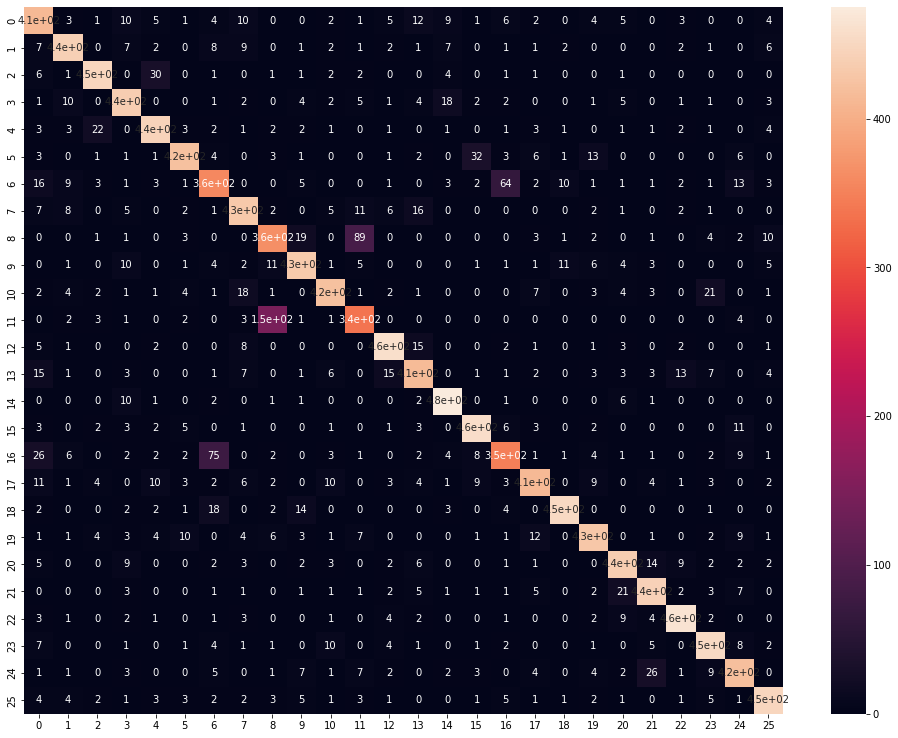

In [93]:
plt.figure(figsize=(17,13))
sns.heatmap(cf_matrix, annot=True)

<BarContainer object of 26 artists>

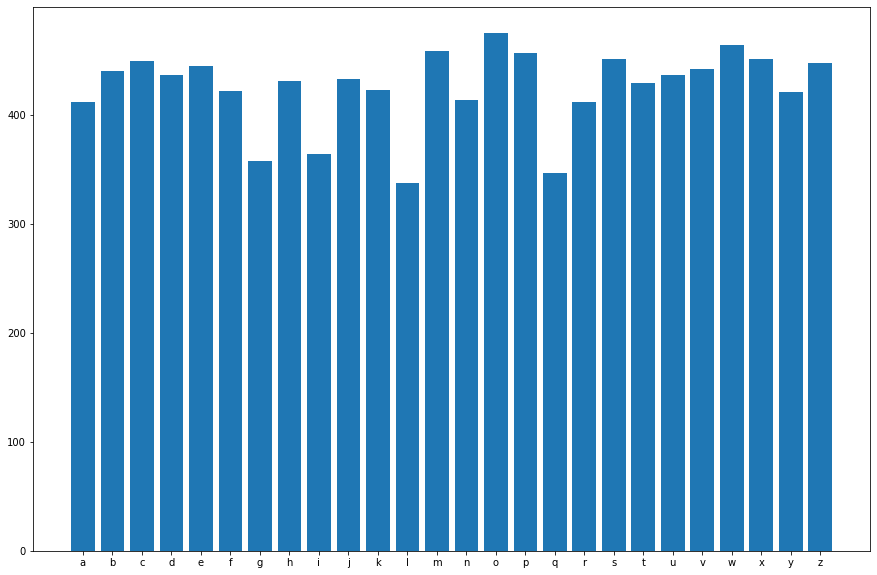

In [127]:
plt.figure(figsize=(15,10))
letters_stat = [cf_matrix[i][i] for i in range(26)]
plt.bar([chr(i+97) for i in range(26)], letters_stat)

In [131]:
chr(np.array(letters_stat).argmax() + 97)

'o'

In [132]:
chr(np.array(letters_stat).argmin() + 97)

'l'

# 1.3

# 1.4 

In [134]:
sind = ord("s") - 97
cf_matrix[sind][sind]/500

0.902

In [135]:
sind

18

судя по confusion_matrix чаще всего модель путает букву "s" с буквами под номерами 6 и 9

In [139]:
chr(97+6), chr(97+9)

('g', 'j')

# 3

здесь выгрузим пару моделей из обученных мной и продемонстрируем результаты на тестовых данных

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.